In [3]:
from deepscore import DeepScore
from preprocessing import *
import scanpy as sc
import anndata as ad

%load_ext rpy2.ipython
%load_ext tensorboard 
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')

In [2]:
#!Rscript /home/pab/projects/utils/seurat2anndata.R /home/pab/projects/ESPACE/adult_pancreas_2020.rds

### First load and process the sample we want to annotate:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


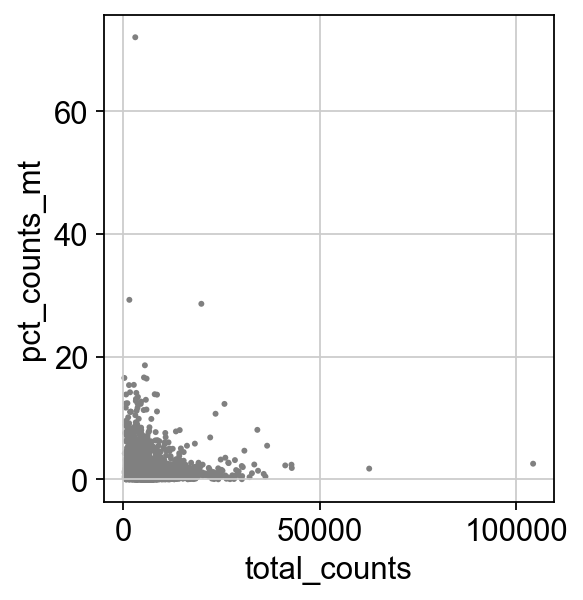

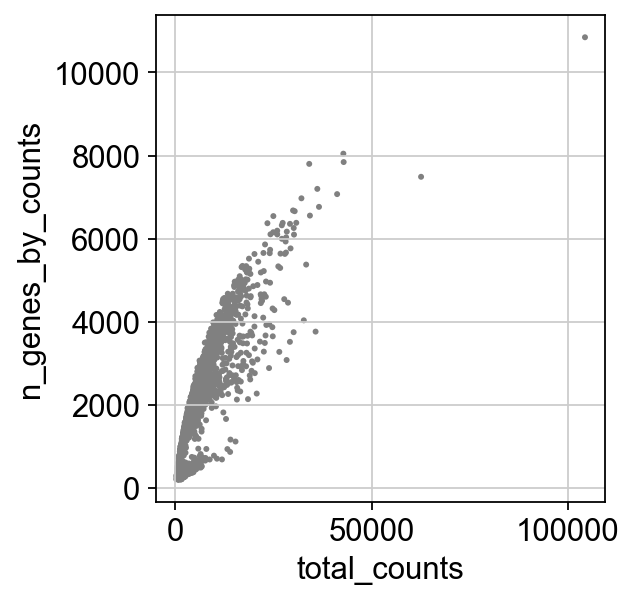

In [4]:
sc.settings.set_figure_params(figsize=('4', '4'), color_map='gist_earth')

# read multiomic data. Gex_only = False is crucial to read both modalities
sample_path = "/home/pab/projects/ESPACE/ESPACE_multiome/sample5/filtered_feature_bc_matrix.h5"
adata = sc.read_10x_h5(sample_path, gex_only = True)
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Now load and process the reference we will use to annotate:

AnnData object with n_obs × n_vars = 112563 × 43815
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'patient_ID', 'sex', 'age', 'pancreas_location', 'procurement_lab', 'Cluster'
    var: 'name'
    obsm: 'X_pca', 'X_umap'


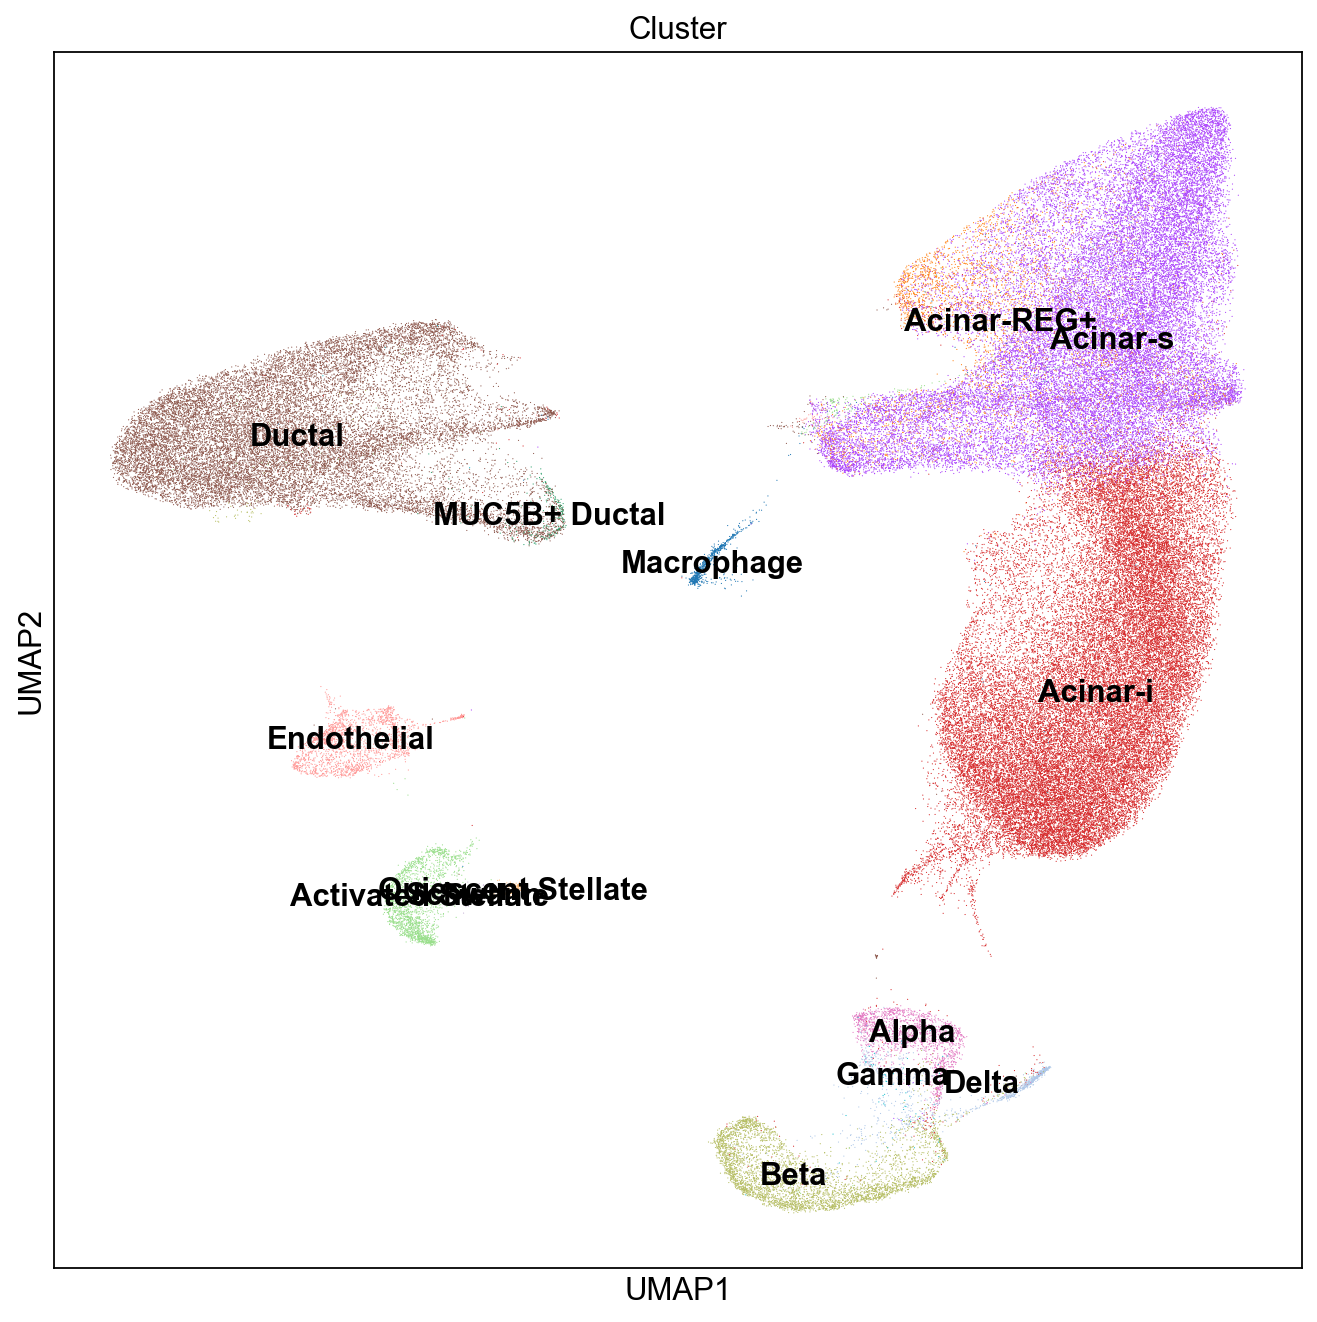

In [6]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')
# Load and process the reference

ref_py = ad.read(f"/home/pab/projects/ESPACE/adult_pancreas_2020.h5ad")
print(ref_py)
sc.pp.normalize_total(ref_py, target_sum=1e4)
sc.pp.log1p(ref_py)
sc.pl.umap(ref_py, color='Cluster', legend_loc = 'on data')

### Find common features between the two datasets and filter the others:

In [7]:
ref_py, adata = find_common_genes(ref_py, adata, target_n_genes=2000)

Dimensions before filtering: (112563, 43815) and (4169, 23552)

Looking for 5000 HVG
Found 1229 genes in common
Looking for 6000 HVG
Found 1570 genes in common
Looking for 7000 HVG
Found 1924 genes in common
Looking for 8000 HVG
Found 2318 genes in common
Filtering the data to these features and scaling



Dimensions after filtering: (112563, 2318) and (4169, 2318)


### Prepare the reference data and train model:

In [8]:
!rm -r logs/*

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


n_feat = ref_py.shape[1]
n_labs = len(ref_py.obs['Cluster'].cat.categories)
ds = DeepScore(hidden_nodes=[128, 64], n_features=n_feat, 
               n_labels=n_labs, batch_size=32, dropout_rate=0.3, 
               epochs=10, weight_reg=True)

ds.set_reference(ref_py, label_by='Cluster', test_prop=0.2)
ds.train(earlystopping=True, patience=10, lr_scheduler=scheduler)
ds.model.save('rna_pancreas')

rm: cannot remove 'logs/*': No such file or directory


2021-10-27 15:44:33.125723: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-10-27 15:44:33.125807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kino
2021-10-27 15:44:33.125827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kino
2021-10-27 15:44:33.126035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.91.3
2021-10-27 15:44:33.126100: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.91.3
2021-10-27 15:44:33.126148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.91.3
2021-10-27 15:44:33.126847: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations

Model: "deepscore"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 2318)              9272      
_________________________________________________________________
dense128 (Dense)             (None, 128)               296832    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense64 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                25

2021-10-27 15:44:42.769295: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 834943600 exceeds 10% of free system memory.
2021-10-27 15:44:43.171653: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 15:44:43.171679: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 15:44:43.173212: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 15:44:43.173926: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 751449240 exceeds 10% of free system memory.
2021-10-27 15:44:43.456503: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
  71/2533 [..............................] - ETA: 7s - loss: 1.8825 - categorical_accuracy: 0.4520

2021-10-27 15:44:44.182951: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 15:44:44.182973: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 15:44:44.186641: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 15:44:44.187849: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 15:44:44.200079: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./deepscore_logs/train/plugins/profile/2021_10_27_15_44_44

2021-10-27 15:44:44.201338: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./deepscore_logs/train/plugins/profile/2021_10_27_15_44_44/kino.trace.json.gz
2021-10-27 15:44:44.204144: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./deepscore_logs/train/plugins/profile/2021_10_27_15_44_44

2

2533/2533 [==============================] - 7s 3ms/step - loss: 0.4596 - categorical_accuracy: 0.8558 - val_loss: 0.2601 - val_categorical_accuracy: 0.9063
Epoch 2/10
2533/2533 [==============================] - 6s 2ms/step - loss: 0.3009 - categorical_accuracy: 0.8941 - val_loss: 0.2668 - val_categorical_accuracy: 0.9046
Epoch 3/10
2533/2533 [==============================] - 6s 2ms/step - loss: 0.2827 - categorical_accuracy: 0.8992 - val_loss: 0.2682 - val_categorical_accuracy: 0.9066
Epoch 4/10
2533/2533 [==============================] - 6s 2ms/step - loss: 0.2733 - categorical_accuracy: 0.9018 - val_loss: 0.2722 - val_categorical_accuracy: 0.9035
Epoch 5/10
2533/2533 [==============================] - 6s 2ms/step - loss: 0.2688 - categorical_accuracy: 0.9031 - val_loss: 0.2625 - val_categorical_accuracy: 0.9045
Epoch 6/10
2533/2533 [==============================] - 6s 2ms/step - loss: 0.2645 - categorical_accuracy: 0.9033 - val_loss: 0.2697 - val_categorical_accuracy: 0.9036
Epo

2021-10-27 15:45:45.396097: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rna_pancreas/assets


### Predict the celltypes in our sample using the trained model:

... storing 'Deepscore' as categorical


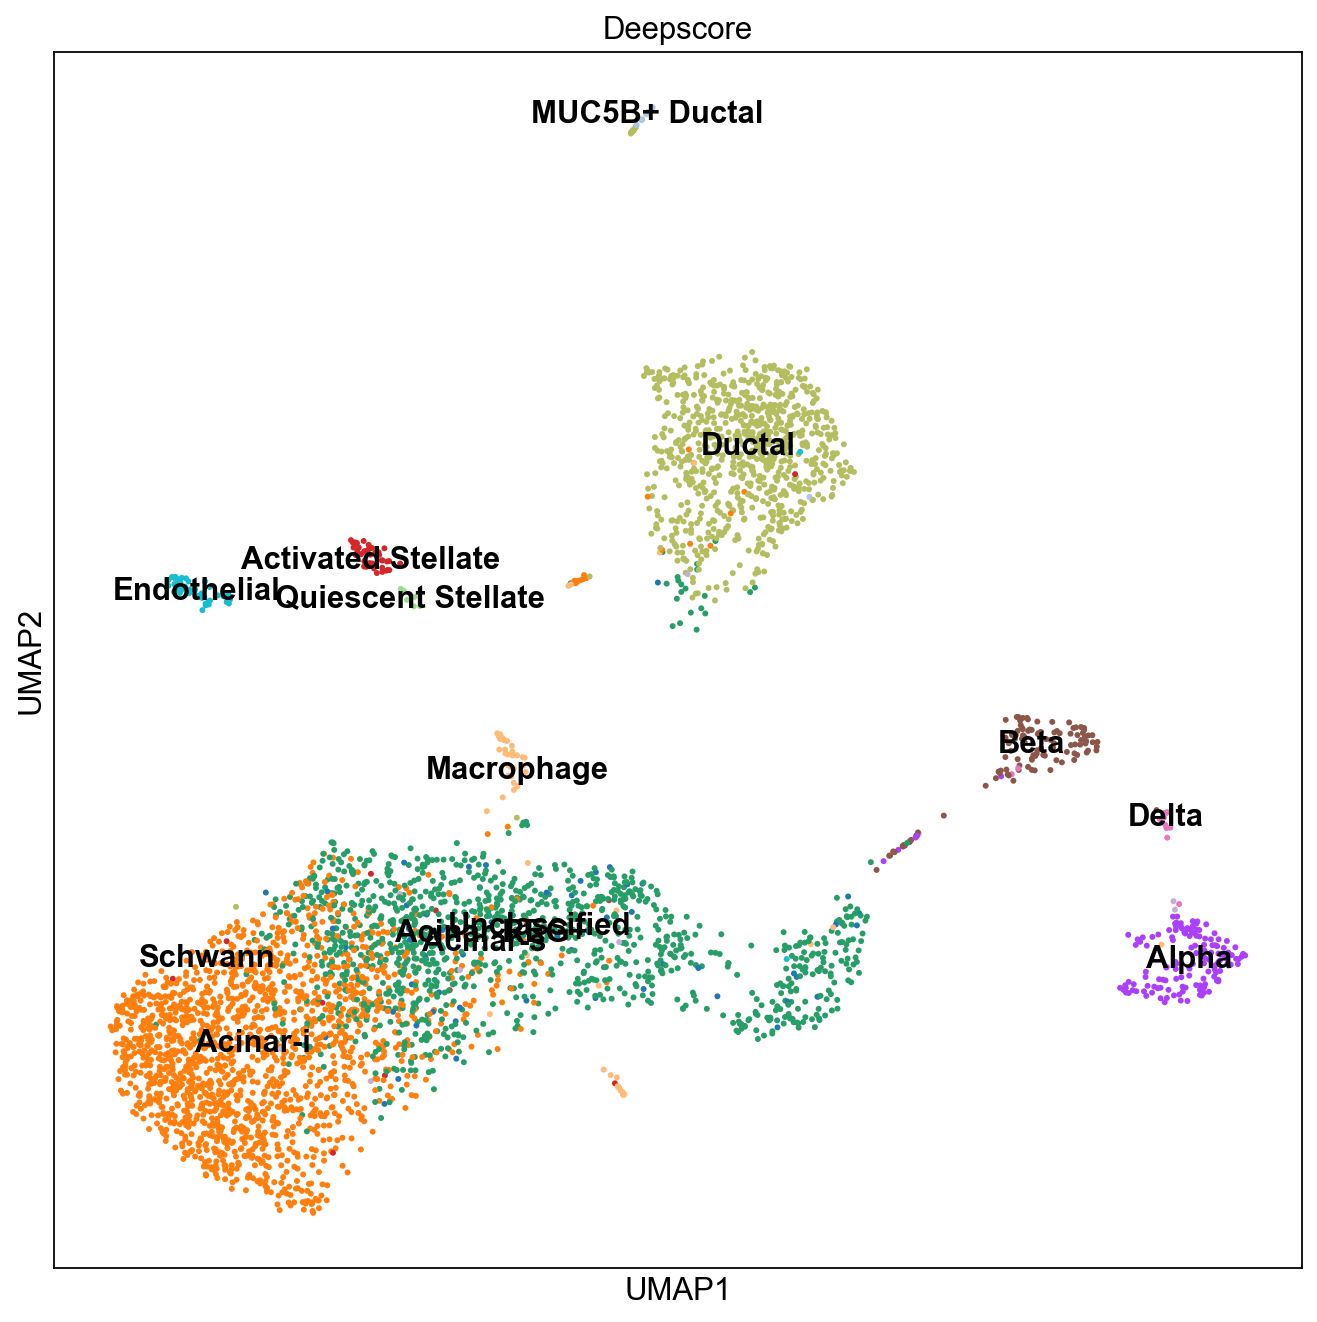

In [9]:
adata = ds.annotate(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='Deepscore', legend_loc='on data')

In [10]:
%tensorboard --logdir deepscore_logs

In [12]:
# To eliminate predicted celltypes with less than 5 cells for DEA
adata.obs['Deepscore'].value_counts()
dfn = adata.obs['Deepscore'].value_counts() > 5
keep_celltypes = dfn[dfn == True].index.to_list()
adata = adata[adata.obs['Deepscore'].isin(keep_celltypes)]

In [19]:
sc.tl.rank_genes_groups(ref_py, 'Cluster', method='wilcoxon')
sc.tl.rank_genes_groups(adata, 'Deepscore', method='wilcoxon')

In [20]:
ref_markers = top_markers(ref_py, ntop=100)
sample_markers = top_markers(adata, ntop=100)
ref_markers.head(5), sample_markers.head(5)

(  Macrophage Acinar-REG+ MUC5B+ Ductal  Acinar-i Acinar-s  Ductal   Alpha  \
 0       CD74       REG3A         THSD4   ZNF804B    PRSS1   BICC1  KCNMB2   
 1     PLXDC2       REG1A       SHROOM3    PLXNA2     SYCN    CFTR    GPC6   
 2    HLA-DRA       REG1B          TMC5     LRIG1    REG1A  SLC4A4     TTR   
 3   HLA-DRB1       REG3G         KRT19  CATSPERB     KLK1   GLIS3     GCG   
 4       ZEB2      SPINK1        S100A6      NTN4    AMY2B   ANXA4   MAGI2   
 
       Beta   Gamma     Delta Quiescent Stellate Activated Stellate  \
 0  SLC30A8     PPY    KCNMB2              CALD1              NEGR1   
 1  ZNF385D  KCNMB2     RIMS2             IGFBP7              RBMS3   
 2    TRPM3   NRXN1     MAGI2             COL4A2              LAMA2   
 3    ABCC8   RIMS2   CACNA1A            SPARCL1              TSHZ2   
 4   KCNMB2   MEIS2  TMEM132D               MYL9              CALD1   
 
   Endothelial Schwann  
 0        LDB2   CALD1  
 1     SLCO2A1   RBMS3  
 2  ST6GALNAC3  IGFBP7  
 3

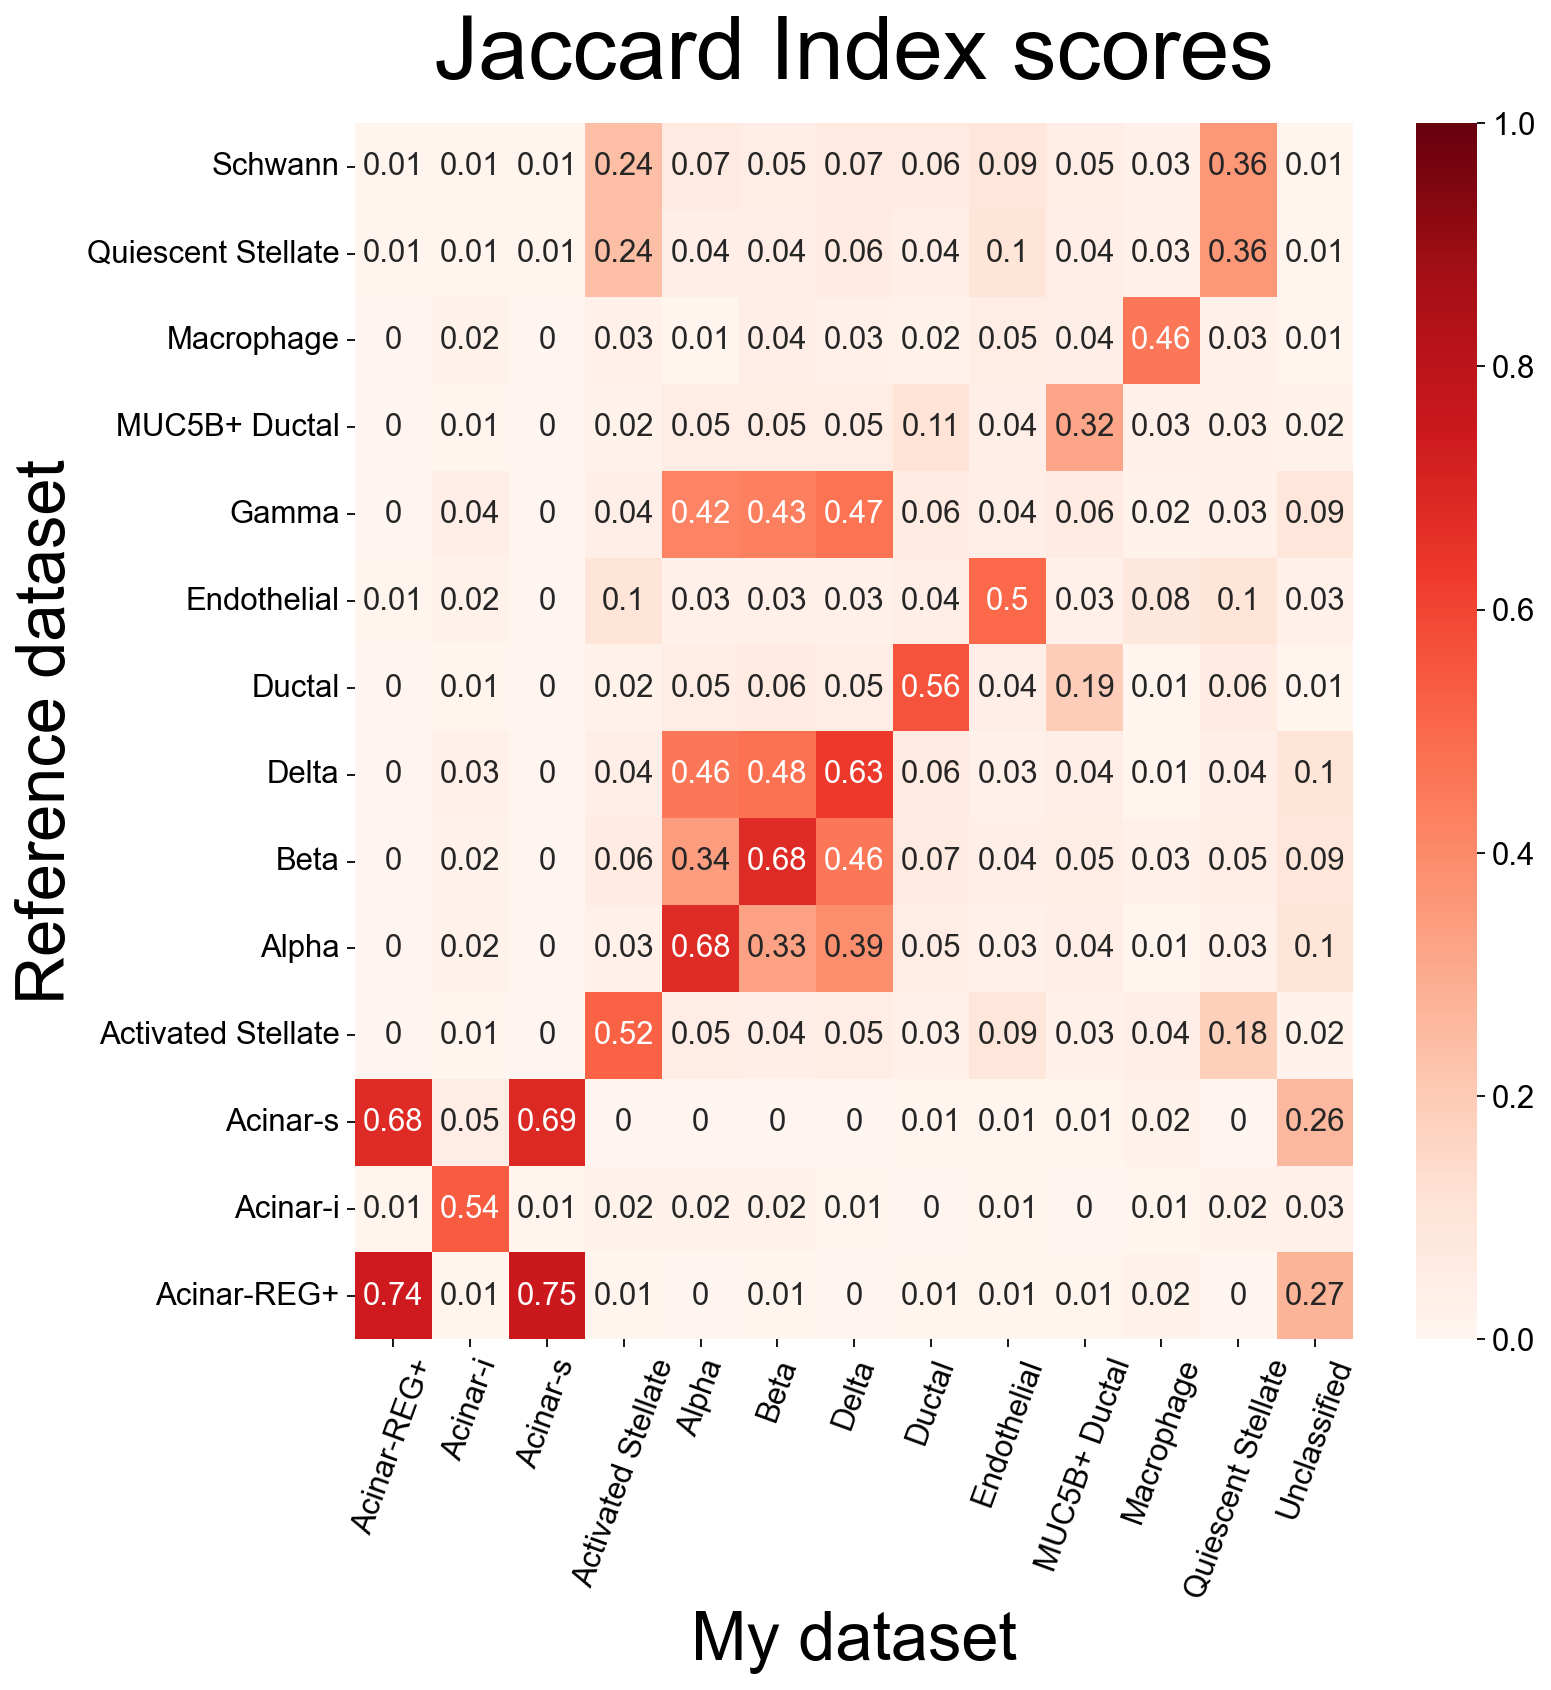

In [21]:
ms = matchscore(ref_markers, sample_markers, plot=True)